In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

In [4]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [5]:
num_classes = 10
no_users = 20
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [6]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))/255
x_test = np.reshape(x_test, (x_test.shape[0], -1))/255

In [7]:
x_train = x_train[:10000,:]
y_train = y_train[:10000,:]
x_test = x_test[:2000,:]
y_test = y_test[:2000,:]

In [9]:
class User:
    def __init__(self):
        self.W1 = tf.Variable(tf.random.truncated_normal([784,128], stddev=0.1))
        self.W2 = tf.Variable(tf.random.truncated_normal([128,64], stddev=0.1))
        self.W3 = tf.Variable(tf.random.truncated_normal([64,10], stddev=0.1))
        
        self.gW1 = tf.Variable(tf.random.truncated_normal([784,128], stddev=0.1))
        self.gW2 = tf.Variable(tf.random.truncated_normal([128,64], stddev=0.1))
        self.gW3 = tf.Variable(tf.random.truncated_normal([64,10], stddev=0.1))

        #self.lambda_W1 = tf.Variable(tf.zeros([784*128,1]))
        #self.lambda_W2 = tf.Variable(tf.zeros([128*64,1]))
        #self.lambda_W3 = tf.Variable(tf.zeros([64*10,1]))

    def neural_net(self, x):
        y1 = tf.nn.relu(tf.matmul(x, self.W1))
        y2 = tf.nn.relu(tf.matmul(y1, self.W2))
        ylogits = tf.matmul(y2, self.W3)
        return tf.nn.softmax(ylogits)

In [10]:
# mini-batch loss function.
def mini_batches(X, Y, mb_size):

    m = X.shape[0]
    perm = list(np.random.permutation(m))
    X_temp = X[perm,:]
    Y_temp = Y[perm,:].reshape((m, Y.shape[1]))
    
    X_r = tf.convert_to_tensor(X_temp[0:mb_size,:], dtype=np.float32)
    Y_r = tf.convert_to_tensor(Y_temp[0:mb_size,:], dtype=np.float32)
    return X_r,Y_r

In [11]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return -tf.reduce_sum(y_true * tf.math.log(y_pred))

In [12]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [13]:
# Optimization process. 
def get_gradients(x, y, W1, W2, W3):
    # Variables to update, i.e. trainable variables.
    trainable_variables = [W1, W2, W3]
    
    with tf.GradientTape() as g:
        g.watch([W1,W2,W3])
        y1 = tf.nn.relu(tf.matmul(x, W1))
        y2 = tf.nn.relu(tf.matmul(y1, W2))
        ylogits = tf.matmul(y2, W3)
        pred = tf.nn.softmax(ylogits)
        loss = cross_entropy(pred, y) 
    
    # Compute gradients.
    gradients1, gradients2, gradients3  = g.gradient(loss, trainable_variables)
    
    return gradients1, gradients2, gradients3, loss

In [14]:
users = [User() for i in range(no_users)]
#rho = 20
eta = 100
central_modal = [tf.Variable(tf.random.truncated_normal([784*128,1], stddev=0.1)),\
                 tf.Variable(tf.random.truncated_normal([128*64,1], stddev=0.1)),\
                 tf.Variable(tf.random.truncated_normal([64*10,1], stddev=0.1))]

In [15]:
x_train_k = []
y_train_k = []
data_per_worker = int(x_train.shape[0]/no_users)
for i in range(no_users):
    first = i*data_per_worker
    last = first + data_per_worker
    x_train_k.append(x_train[first:last])
    y_train_k.append(y_train[first:last])

In [16]:
x_test = tf.convert_to_tensor(x_test, dtype=np.float32)
y_test = tf.convert_to_tensor(y_test, dtype=np.float32)

In [17]:
mb_size = 100
n_epochs = 500
lr = 0.001
n_localIter=10

In [18]:
Train_Acc = []
Test_Acc = []
acc_train = np.zeros([n_epochs,1])
acc_test = np.zeros([n_epochs,1])
total_loss = np.zeros([n_epochs,1])

for i in range(no_users):
    users[i].W1.assign(tf.reshape(central_modal[0],[784,128]))
    users[i].W2.assign(tf.reshape(central_modal[1],[128,64]))
    users[i].W3.assign(tf.reshape(central_modal[2],[64,10]))
            
for k in range(n_epochs):               
        batch_x = []
        batch_y = []
        for i in range(no_users):
            batch_xx , batch_yy = mini_batches(x_train_k[i],y_train_k[i],  mb_size)
            batch_x.append(batch_xx)
            batch_y.append(batch_yy) 
        for i in range(no_users):

            gradients1, gradients2, gradients3, loss= get_gradients(batch_x[i], batch_y[i], users[i].W1,\
                                                                        users[i].W2, users[i].W3)               
                                           
            users[i].gW1.assign(gradients1)
            users[i].gW2.assign(gradients2)
            users[i].gW3.assign(gradients3)
            total_loss[k] = total_loss[k] + loss
            
            
        ############
            
            w_1 = tf.reshape(users[i].W1,[784*128, 1])-lr*(tf.reshape(users[i].gW1,[784*128, 1]))
            w_2 = tf.reshape(users[i].W2,[128*64, 1]) -lr*(tf.reshape(users[i].gW2,[128*64, 1]) )
            w_3 = tf.reshape(users[i].W3,[64*10, 1]) -lr*(tf.reshape(users[i].gW3,[64*10, 1]) )
            
            users[i].W1.assign(tf.reshape(w_1,[784,128]))
            
            users[i].W2.assign(tf.reshape(w_2,[128,64]) )
            users[i].W3.assign(tf.reshape(w_3,[64,10]) )
            
        
        if k%n_localIter==0:
            temp11 = 0
            temp21 = 0
            temp31 = 0              
            
            # 1 Updating central model params using simple averaging 
            for i in range(no_users):           
                temp11 = temp11 + tf.reshape(users[i].W1,[784*128, 1])
                temp21 = temp21 + tf.reshape(users[i].W2,[128*64, 1]) 
                temp31 = temp31 + tf.reshape(users[i].W3,[64*10, 1]) 

            # Update central model 1
            central_modal[0] = 1/(no_users)*(temp11)
            central_modal[1] = 1/(no_users)*(temp21)
            central_modal[2] = 1/(no_users)*(temp31)
            
            # 2 Updating central model params using SGD
            #for i in range(no_users):           
            #    temp11 = temp11 + tf.reshape(users[i].gW1,[784*128, 1])
            #    temp21 = temp21 + tf.reshape(users[i].gW2,[128*64, 1]) 
            #    temp31 = temp31 + tf.reshape(users[i].gW3,[64*10, 1]) 
            # Update central model 2
            #central_modal[0] = central_modal[0]-1/(no_users)*lr*(temp11)
            #central_modal[1] = central_modal[1]-1/(no_users)*lr*(temp21)
            #central_modal[2] = central_modal[2]-1/(no_users)*lr*(temp31)

            
        ########################
            for i in range(no_users):

                users[i].W1.assign(tf.reshape(central_modal[0],[784,128]))
                users[i].W2.assign(tf.reshape(central_modal[1],[128,64]))
                users[i].W3.assign(tf.reshape(central_modal[2],[64,10]))       
        
        train_acc = []
        test_acc = []
        for j in range(no_users):  
            train_pred = users[j].neural_net(batch_x[j])
            train_acc.append(accuracy(train_pred, batch_y[j]))
            test_pred = users[j].neural_net(x_test)
            test_acc.append(accuracy(test_pred, y_test))
        avgAcc_Train = np.mean(train_acc)
        avgAcc_Test = np.mean(test_acc)
        print('Train accuracy', avgAcc_Train)
        print('Test accuracy',avgAcc_Test)
        acc_train[k] = avgAcc_Train
        acc_test[k] = avgAcc_Test        

Train accuracy 0.12299998
Test accuracy 0.1255
Train accuracy 0.1765
Test accuracy 0.1525
Train accuracy 0.21800001
Test accuracy 0.179475
Train accuracy 0.2595
Test accuracy 0.20359997
Train accuracy 0.31700003
Test accuracy 0.23397501
Train accuracy 0.342
Test accuracy 0.262375
Train accuracy 0.37350002
Test accuracy 0.28730002
Train accuracy 0.40949997
Test accuracy 0.31989998
Train accuracy 0.45400006
Test accuracy 0.34435
Train accuracy 0.49799997
Test accuracy 0.371525
Train accuracy 0.455
Test accuracy 0.44699994
Train accuracy 0.52349997
Test accuracy 0.45772496
Train accuracy 0.543
Test accuracy 0.471725
Train accuracy 0.554
Test accuracy 0.47255
Train accuracy 0.5655001
Test accuracy 0.48677498
Train accuracy 0.6035
Test accuracy 0.49252504
Train accuracy 0.597
Test accuracy 0.50882494
Train accuracy 0.634
Test accuracy 0.519525
Train accuracy 0.63150007
Test accuracy 0.53207505
Train accuracy 0.65349996
Test accuracy 0.5389
Train accuracy 0.622
Test accuracy 0.5905
Train acc

Train accuracy 0.916
Test accuracy 0.84625006
Train accuracy 0.91550004
Test accuracy 0.84174997
Train accuracy 0.92550004
Test accuracy 0.84139997
Train accuracy 0.9315001
Test accuracy 0.8440999
Train accuracy 0.93050003
Test accuracy 0.848825
Train accuracy 0.9465
Test accuracy 0.84295017
Train accuracy 0.89049995
Test accuracy 0.859
Train accuracy 0.91499996
Test accuracy 0.847075
Train accuracy 0.9214999
Test accuracy 0.84954995
Train accuracy 0.92449987
Test accuracy 0.8437251
Train accuracy 0.92750007
Test accuracy 0.8508499
Train accuracy 0.9269999
Test accuracy 0.849275
Train accuracy 0.9330001
Test accuracy 0.843125
Train accuracy 0.928
Test accuracy 0.846375
Train accuracy 0.92750007
Test accuracy 0.84925
Train accuracy 0.93499994
Test accuracy 0.846125
Train accuracy 0.8955
Test accuracy 0.86300004
Train accuracy 0.9304999
Test accuracy 0.85105
Train accuracy 0.91449994
Test accuracy 0.85077494
Train accuracy 0.9205
Test accuracy 0.8504
Train accuracy 0.93500006
Test accura

Train accuracy 0.954
Test accuracy 0.8702
Train accuracy 0.95150006
Test accuracy 0.86835
Train accuracy 0.96349984
Test accuracy 0.867375
Train accuracy 0.9595
Test accuracy 0.870875
Train accuracy 0.93200004
Test accuracy 0.884
Train accuracy 0.9384999
Test accuracy 0.87782496
Train accuracy 0.9460001
Test accuracy 0.87302506
Train accuracy 0.9499999
Test accuracy 0.87325
Train accuracy 0.94399995
Test accuracy 0.87475
Train accuracy 0.9555
Test accuracy 0.870825
Train accuracy 0.9525
Test accuracy 0.875175
Train accuracy 0.9480001
Test accuracy 0.8712999
Train accuracy 0.9514998
Test accuracy 0.87455
Train accuracy 0.9619999
Test accuracy 0.87504995
Train accuracy 0.9285
Test accuracy 0.886
Train accuracy 0.93899995
Test accuracy 0.8748251
Train accuracy 0.9414999
Test accuracy 0.87255
Train accuracy 0.9545
Test accuracy 0.873875
Train accuracy 0.9534999
Test accuracy 0.87439996
Train accuracy 0.9445001
Test accuracy 0.874025
Train accuracy 0.95100003
Test accuracy 0.87607497
Train 

In [19]:
acc_test[-1]

array([0.88337505])

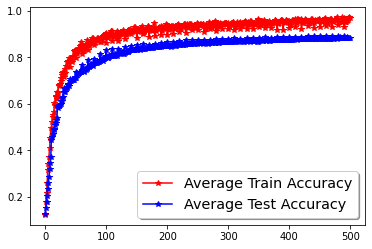

In [21]:
import matplotlib.pyplot as plt

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(range(n_epochs), acc_train, 'r-*', label='Average Train Accuracy')
ax.plot(range(n_epochs), acc_test, 'b-*', label='Average Test Accuracy')

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')

plt.show()

In [24]:
np.save('acc_train_localSGD', acc_train)
np.save('acc_test_localSGD', acc_test)
np.save('loss_localSGD', total_loss/no_users)

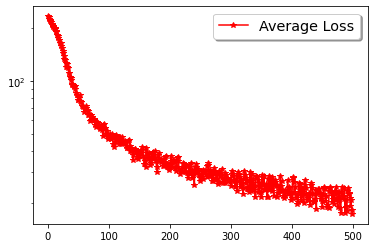

In [23]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(range(n_epochs), total_loss/no_users, 'r-*', label='Average Loss')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

plt.yscale('log')
plt.show()